# Information Retrieval Project

### In order to evaluate the Nordlys toolkit, we want to answer to the following questions:
- How  are  Nordlys  toolkit  performances,  considering  the  different  types  of  questions  (SemSearchES,INEX-LD, QALD2, ListSearch)?
- How are Nordlys performances compared to the Google search engines?


Here we load the list of queries

In [1]:
with open('query_list.txt', 'r') as f:
    text = f.read()
    
raw_queries = text.split("\n")

list_queries=[]
for i in raw_queries:
    list_queries.append(i.split("\t")[1])

In order to calculate MAP and Normalized DCG we need to know how many relevant results exist for each query. Here we make a list of size 3 for each query. The number in index i in the list is the number of rated documents with score i for this query. 

In [2]:
import codecs
f2 = codecs.open("query_relevance.txt", encoding="utf-8")
text = f2.read()


relevance_lines = text.split("\n")

query_counts = {}
current_query = text.split("\n")[0].split("\t")[0]
temp_count_list = [0,0,0]


counter = 0
while (counter < len(relevance_lines)):
    query_name = relevance_lines[counter].split("\t")[0]
    relevance = relevance_lines[counter].split("\t")[3]
    if query_name != current_query:
        query_counts[current_query] = temp_count_list
        current_query = query_name
        temp_count_list = [0,0,0]
        
    temp_count_list[int(relevance)] += 1
    counter += 1
    if counter == len(relevance_lines):
        query_counts[current_query] = temp_count_list


## Calculating Mean Average Precision (MAP) measure

In the following section we will calculate the MAP of a list of query results. The result of a single consists of the name of the query, and a list of tuples containing the retrieved document and the relevancy of that document. These tuples are in the same order as they were returned from the retrieval system. 

Since MAP only works on binary relevancy levels, we have decided that both the level 1 and 2 are relevant while level 0 is not relevant.

P(q,k) calculates the precision of a query q at k retrieved documents but only on steps wher the new retrieved document is considered to be relevant.

In [3]:
import numpy as np

#Returns true if the document is relevant (values 1 and 2)
def rel(q,k,input_queries):
    return int(input_queries[q][k][1]) > 0

#Returns the precision at k for query q
def P(q,k,input_queries):
    k_retrieved = input_queries[q][0:(k)]
    relevant_retrieved = (x for x in k_retrieved if int(x[1]) > 0)    
    return len(list(relevant_retrieved))/(len(k_retrieved)*1.0)

#Takes he average of the precisions of query q for k = max_k
def AveP(q,input_queries,max_k):
    res = 0
    for k in range(0,max_k):
        res += np.dot(P(q,k+1,input_queries),rel(q,k+1,input_queries))
    number_of_relevant = query_counts[q][1] +  query_counts[q][2]
    if (number_of_relevant == 0):
        return 0
    return res/(number_of_relevant*1.0)

def MAP(input_queries, k, verbose=True):    
    res = 0
    count = 0  
    zeroprecs = 0
    for q in input_queries:
        addition = AveP(q,input_queries,k)
        if addition > 0:
            count += 1
            res += addition        
        else:
            zeroprecs += 1
    if verbose:
        print("Number of queeries with avep = 0:", zeroprecs)
    return res/count 

def GMAP(input_queries, k, verbose=True):    
    res = 1
    count = 0
    zeroprecs = 0
    for q in input_queries:
        addition = AveP(q,input_queries,k)
        if addition > 0:
            count += 1
            res += np.log(addition)
        else:
            zeroprecs += 1
    if verbose:
        print("Number of queeries with avep = 0:", zeroprecs)
    return np.exp(res/count)

## Calculating Discounted Cumulative Gain (DCG) measure

Discounted cumulative gain sums the knowledge gain of each retrieved document divided by log2 of the position. This means that a a very important document (rank 2) at position 3 will give a higher score than a very important document at position 10.

For each query we canculate DCG@k meaning that only the first k query results are considered in the calculation.
For the normalization we also calculate IDCG, which is the ideal DCG for a perfect ranking. This is done based on the list how many relevant documents of each rank exists for each query.

Since we have more than one query for each search engine, we return the average NDCG.

In [4]:
import numpy as np

#Calculate Discounted Cumulative Gain
def DCG(query_results,k):
    dcg = float(query_results[0][1])
    for i in range(1,k):
        dcg += float(query_results[i][1])/float(np.log2(i+1))
    return dcg

#The score for a perfect ranking
def IDCG(q,k):
    #savek in j for later
    j = k
    relevant_for_query = query_counts[q]
    gains = []
    #Add all gains of 2 and subtract that number from k
    for i in range(min(k,relevant_for_query[2])):     
        gains.append(["Dummy",2])
    k = k-relevant_for_query[2]
    #Add all gains of 1 and subtract that number from k
    for i in range(min(k,relevant_for_query[1])):      
        gains.append(["Dummy",1])
    k = k-relevant_for_query[1]
    #Fill the rest of the list with gain of 0 to avoid indexing problems
    for i in range(k):
        gains.append(["Dummy",0])        
    
    idcg = DCG(gains,j)    
    #print(idcg)
    return idcg

#Calculates the average NDCG for the first k documents, only if the retrieved documents >= 20 
def AvgNDCG(input_queries,k):
    sum_ndcg = 0
    for q in input_queries:
        addition = (DCG(input_queries[q],k)/IDCG(q,k))  #NDCG
        sum_ndcg += addition
    return sum_ndcg/len(input_queries)  
        


In [5]:
#Reading function. It adds fake documents for having 20 retrieved documents for each queries
import codecs
import json

def is_dublicate(results, current_result):
    count = 0
    for i in range(len(results)):
        if results[i][0] == current_result[0]:    
            count += 1
            if count > 1:
                results[i][1] = 0
    return results
                

def read_queries(file_name):
    query_reader = codecs.open(file_name, encoding="utf-8")
    text = query_reader.read()
    queries = json.loads(text)

    for q in queries:
        for i in range(len(queries[q])):
            queries[q] = is_dublicate(queries[q], queries[q][i])                
        for x in range(20-len(queries[q])):
            queries[q].append(["Dummy",0])
    return queries




## Calculations for Nordlys

In [6]:
Nordlys_queries= read_queries("nordlys_retrievals_jm.txt")

print(AvgNDCG(Nordlys_queries,10))
print(GMAP(Nordlys_queries,10))
print(MAP(Nordlys_queries,10))

0.2755483431337512
Number of queeries with avep = 0: 201
0.0493284202618
Number of queeries with avep = 0: 201
0.0914202350323


# Calculations for Google

In [7]:
Google_queries = read_queries("google_retrieval_dict.json")
        
print(AvgNDCG(Google_queries,10))
print(GMAP(Google_queries,10))
print(MAP(Google_queries,10))

0.16755585364955514
Number of queeries with avep = 0: 317
0.0372262643221
Number of queeries with avep = 0: 317
0.0719614154505


# Comparison of scores

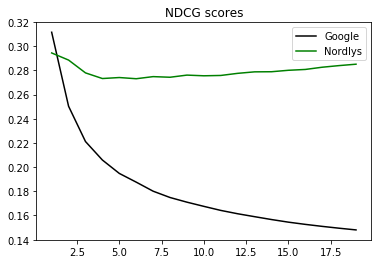

Number of queeries with avep = 0: 392
Number of queeries with avep = 0: 378
Number of queeries with avep = 0: 368
Number of queeries with avep = 0: 329
Number of queeries with avep = 0: 352
Number of queeries with avep = 0: 301
Number of queeries with avep = 0: 341
Number of queeries with avep = 0: 273
Number of queeries with avep = 0: 333
Number of queeries with avep = 0: 254
Number of queeries with avep = 0: 326
Number of queeries with avep = 0: 235
Number of queeries with avep = 0: 324
Number of queeries with avep = 0: 228
Number of queeries with avep = 0: 319
Number of queeries with avep = 0: 218
Number of queeries with avep = 0: 317
Number of queeries with avep = 0: 211
Number of queeries with avep = 0: 317
Number of queeries with avep = 0: 201
Number of queeries with avep = 0: 314
Number of queeries with avep = 0: 195
Number of queeries with avep = 0: 313
Number of queeries with avep = 0: 189
Number of queeries with avep = 0: 312
Number of queeries with avep = 0: 179
Number of qu

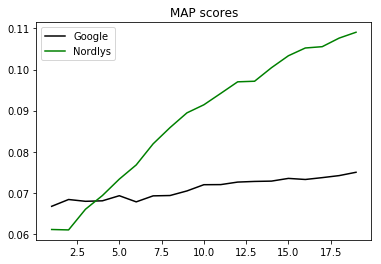

Number of queeries with avep = 0: 392
Number of queeries with avep = 0: 378
Number of queeries with avep = 0: 368
Number of queeries with avep = 0: 329
Number of queeries with avep = 0: 352
Number of queeries with avep = 0: 301
Number of queeries with avep = 0: 341
Number of queeries with avep = 0: 273
Number of queeries with avep = 0: 333
Number of queeries with avep = 0: 254
Number of queeries with avep = 0: 326
Number of queeries with avep = 0: 235
Number of queeries with avep = 0: 324
Number of queeries with avep = 0: 228
Number of queeries with avep = 0: 319
Number of queeries with avep = 0: 218
Number of queeries with avep = 0: 317
Number of queeries with avep = 0: 211
Number of queeries with avep = 0: 317
Number of queeries with avep = 0: 201
Number of queeries with avep = 0: 314
Number of queeries with avep = 0: 195
Number of queeries with avep = 0: 313
Number of queeries with avep = 0: 189
Number of queeries with avep = 0: 312
Number of queeries with avep = 0: 179
Number of qu

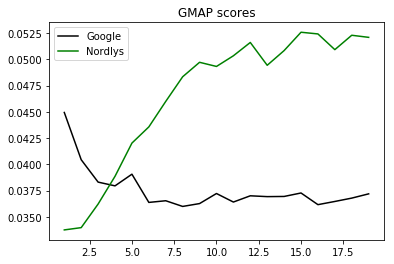

In [8]:
import matplotlib.pyplot as plt

measures = {
    'ndcg': [AvgNDCG, 'NDCG scores', 'NDCG_scores'], 
    'map': [MAP, 'MAP scores', 'MAP_scores'], 
    'gmap': [GMAP, 'GMAP scores', 'GMAP_scores']
}

def calculate_and_plot_eval_measure(eval_measure, google_queries, nordlys_queries):
    google_scores = []
    nordlys_scores = []    
    for i in range (1,20):
        google_scores.append(measures[eval_measure][0](Google_queries,i))
        nordlys_scores.append(measures[eval_measure][0](Nordlys_queries,i))
    
    plt.figure()
    ax = plt.subplot(111)
    plt.plot()
    plt.plot(np.arange(1,20,1), google_scores, color='black', label='Google')
    plt.plot(np.arange(1,20,1), nordlys_scores, color='green', label='Nordlys')
    ax.set_title(measures[eval_measure][1])

    ax.legend()
    plt.show()
    plt.savefig(measures[eval_measure][2] + '.png')
    
for measure in measures:
    calculate_and_plot_eval_measure(measure, Google_queries, Nordlys_queries)
    

The scores for both MAP and NDCG are significantly lower for Google than for Nordlys. This is surprising as we predicted that Google would be better.
One reason that it is lower is that Google retrieved documents that are relevant, but they are not included in the 200 rated documents for the query. This has forced us to rate these documents as not relevant. Too see how much of a problem this is, we have manually rated the retrieved documents from a few queries and done the expiriments again for this subset of queries.

### Manual assessments

General assessments

In [9]:
manual_nordlys= read_queries("manual_assessments_nordlys_All.json")
manual_google= read_queries("manual_assessments_google_All.json")

print('Nordlys')
print('Average NDCG: ', AvgNDCG(manual_nordlys,10))
print('GMAP: ', GMAP(manual_nordlys,10, False))
print('MAP: ', MAP(manual_nordlys,10, False))

print('----------------------------------------------')
print('Google')
print('Average NDCG: ', AvgNDCG(manual_google,10))
print('GMAP: ', GMAP(manual_google,10, False))
print('MAP: ', MAP(manual_google,10, False))


print('----------------------------------------------')
print('Difference (google - nordlys)')

print('Average NDCG: ', AvgNDCG(manual_google,10) - AvgNDCG(manual_nordlys, 10))
print('GMAP: ', GMAP(manual_google,10, False) - GMAP(manual_nordlys, 10, False))
print('MAP: ', MAP(manual_google,10, False) - MAP(manual_nordlys, 10, False))

Nordlys
Average NDCG:  0.3500490129550182
GMAP:  0.0763222104746
MAP:  0.12369820084
----------------------------------------------
Google
Average NDCG:  0.40085754288489894
GMAP:  0.080688428429
MAP:  0.155823374006
----------------------------------------------
Difference (google - nordlys)
Average NDCG:  0.05080852992988072
GMAP:  0.00436621795442
MAP:  0.0321251731664


INEX assessments

In [10]:
manual_nordlys_INEX= read_queries("manual_assessments_nordlys_INEX.json")
manual_google_INEX= read_queries("manual_assessments_google_INEX.json")

print('Nordlys')
print('Average NDCG: ', AvgNDCG(manual_nordlys_INEX,10))
print('GMAP: ', GMAP(manual_nordlys_INEX,10, False))
print('MAP: ', MAP(manual_nordlys_INEX,10, False))

print('----------------------------------------------')
print('Google')
print('Average NDCG: ', AvgNDCG(manual_google_INEX,10))
print('GMAP: ', GMAP(manual_google_INEX,10, False))
print('MAP: ', MAP(manual_google_INEX,10, False))


print('----------------------------------------------')
print('Difference (google - nordlys)')

print('Average NDCG: ', AvgNDCG(manual_google_INEX,10) - AvgNDCG(manual_nordlys_INEX, 10))
print('GMAP: ', GMAP(manual_google_INEX,10, False) - GMAP(manual_nordlys_INEX, 10, False))
print('MAP: ', MAP(manual_google_INEX,10, False) - MAP(manual_nordlys_INEX, 10, False))


Nordlys
Average NDCG:  0.36314961285394226
GMAP:  0.0918053943228
MAP:  0.0953891436848
----------------------------------------------
Google
Average NDCG:  0.49606988289054893
GMAP:  0.0663596224637
MAP:  0.125230687752
----------------------------------------------
Difference (google - nordlys)
Average NDCG:  0.13292027003660667
GMAP:  -0.0254457718591
MAP:  0.0298415440675


QALD2 assessments

In [11]:
manual_nordlys = read_queries("manual_assessments_nordlys_QALD2.json")
manual_google = read_queries("manual_assessments_google_QALD2.json")

print('Nordlys')
print('Average NDCG: ', AvgNDCG(manual_nordlys,5))
print('GMAP: ', GMAP(manual_nordlys,5, False))
print('MAP: ', MAP(manual_nordlys,5, False))

print('----------------------------------------------')
print('Google')
print('Average NDCG: ', AvgNDCG(manual_google,5))
print('GMAP: ', GMAP(manual_google,5, False))
print('MAP: ', MAP(manual_google,5, False))


print('----------------------------------------------')
print('Difference (google - nordlys)')

print('Average NDCG: ', AvgNDCG(manual_google,5) - AvgNDCG(manual_nordlys, 5))
print('GMAP: ', GMAP(manual_google,5, False) - GMAP(manual_nordlys, 5, False))
print('MAP: ', MAP(manual_google,5, False) - MAP(manual_nordlys, 5, False))

Nordlys
Average NDCG:  0.203054389083616
GMAP:  0.0389638642874
MAP:  0.0450549450549
----------------------------------------------
Google
Average NDCG:  0.5059724686488688
GMAP:  0.183860663836
MAP:  0.274782608696
----------------------------------------------
Difference (google - nordlys)
Average NDCG:  0.3029180795652528
GMAP:  0.144896799549
MAP:  0.229727663641


TREC assessments

In [12]:
manual_nordlys = read_queries("manual_assessments_nordlys_TREC.json")
manual_google = read_queries("manual_assessments_google_TREC.json")

print('Nordlys')
print('Average NDCG: ', AvgNDCG(manual_nordlys,5))
print('GMAP: ', GMAP(manual_nordlys,5, False))
print('MAP: ', MAP(manual_nordlys,5, False))

print('----------------------------------------------')
print('Google')
print('Average NDCG: ', AvgNDCG(manual_google,5))
print('GMAP: ', GMAP(manual_google,5, False))
print('MAP: ', MAP(manual_google,5, False))


print('----------------------------------------------')
print('Difference (google - nordlys)')

print('Average NDCG: ', AvgNDCG(manual_google,5) - AvgNDCG(manual_nordlys, 5))
print('GMAP: ', GMAP(manual_google,5, False) - GMAP(manual_nordlys, 5, False))
print('MAP: ', MAP(manual_google,5, False) - MAP(manual_nordlys, 5, False))

Nordlys
Average NDCG:  0.2906501749104693
GMAP:  0.033517060904
MAP:  0.0455849684585
----------------------------------------------
Google
Average NDCG:  0.36721396445609933
GMAP:  0.0515703686497
MAP:  0.0701599975923
----------------------------------------------
Difference (google - nordlys)
Average NDCG:  0.07656378954563003
GMAP:  0.0180533077457
MAP:  0.0245750291337
